# LangGraph: Simple examples

## Minimal Hello World 

Idea: START --> node --> END

In [118]:
from typing import List, Dict, Any, Optional, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from pprint import pprint, pformat
import logging

logging.basicConfig(level=logging.INFO)

### Define the schema

In [119]:
USER_NAME_KEY = "user_name"
OUTPUT_KEY = "output"
COUNTER_KEY = "counter"

class AgentState(TypedDict):
    """State for the agent. (schema)"""
    user_name: str
    output: List[str]
    

### Define the nodes

In [120]:
def greeting_node(state: AgentState) -> AgentState:
    """
        user_name: should be the user's name
        output: Greet the user.
    """
    # update the state
    logging.info(f"Greeting user: {state[USER_NAME_KEY]}")
    state[OUTPUT_KEY].append(f"Hello, {state[USER_NAME_KEY]}!")
    return state


### Create the graph


In [121]:
graph = StateGraph(AgentState)

GREETING_NODE = "greeting"
graph.add_node(GREETING_NODE, greeting_node)
graph.set_entry_point(GREETING_NODE)
graph.set_finish_point(GREETING_NODE)

app = graph.compile() # compiles but does not validate

### Visualize the current graph


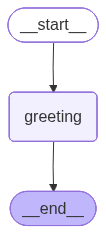

In [122]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


### Run the application

Here, we assume that the name was already given by an external application

In [123]:
result = app.invoke({USER_NAME_KEY: "John", OUTPUT_KEY: []})
logging.info(pformat(result))

INFO:root:Greeting user: John
INFO:root:{'output': ['Hello, John!'], 'user_name': 'John'}


## Extend flow with asking for the username

### Define new node where the user is asked for a name

In [124]:
def ask_user_name(state: AgentState) -> AgentState:
    """
        asks the user for their name
        stores the name in the state
    """
    logging.info("Interactive: Ask for user name")
    state["output"].append("Please enter your name: ")  
    state["user_name"] = input(state["output"][-1])
    return state

### Define new graph with user input

In [125]:
graph = StateGraph(AgentState)

ASK_USER_NAME_NODE = "ask_user_name"
graph.add_node(ASK_USER_NAME_NODE, ask_user_name)

GREETING_NODE = "greeting"
graph.add_node(GREETING_NODE, greeting_node)

graph.add_edge(START, ASK_USER_NAME_NODE)
graph.add_edge(ASK_USER_NAME_NODE, GREETING_NODE)
graph.add_edge(GREETING_NODE, END)

app = graph.compile()  # compiles but does not validate

### Visualize graph

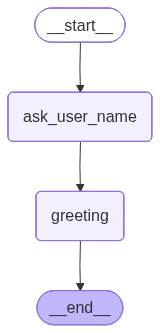

In [126]:
display(Image(app.get_graph().draw_mermaid_png()))

### Run the application

In [127]:
result = app.invoke({OUTPUT_KEY: []})
logging.info(pformat(result))

INFO:root:Interactive: Ask for user name
INFO:root:Greeting user: fffooo
INFO:root:{'output': ['Please enter your name: ', 'Hello, fffooo!'],
 'user_name': 'fffooo'}


## Only ask for name if unknown

### Define a condition node

In [128]:
def should_ask_user_name(state: AgentState) -> Literal[ASK_USER_NAME_NODE, GREETING_NODE]:
    """
        returns the node to go to next
        if the user name is not known, ask for it
        otherwise, go to the greeting node
    """
    logging.info(f"User name: {state[USER_NAME_KEY]}")
    if USER_NAME_KEY in state and state[USER_NAME_KEY] is not None:
        logging.info("let's go to the greeting node")
        return GREETING_NODE
    else:
        logging.info("let's go to the ask user name node")
        return ASK_USER_NAME_NODE

### Define graph with a conditional edge

In [129]:
graph = StateGraph(AgentState)

ASK_USER_NAME_NODE = "ask_user_name"
graph.add_node(ASK_USER_NAME_NODE, ask_user_name)

GREETING_NODE = "greeting"
graph.add_node(GREETING_NODE, greeting_node)

# conditional edge with a dictionary of edges for nice graph visualization
graph.add_conditional_edges(START, should_ask_user_name)
graph.add_edge(ASK_USER_NAME_NODE, GREETING_NODE)
graph.add_edge(GREETING_NODE, END)

app_with_conditional_edge = graph.compile()  # compiles but does not validate

### Show graph

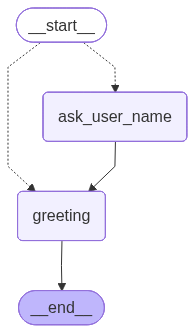

In [130]:
display(Image(app_with_conditional_edge.get_graph().draw_mermaid_png()))

### Run application

#### Run application with an already given user name

In [131]:
result = app_with_conditional_edge.invoke(
    {USER_NAME_KEY: "John", OUTPUT_KEY: [], "greeting": ""})
logging.info(pformat(result))

INFO:root:User name: John
INFO:root:let's go to the greeting node
INFO:root:Greeting user: John
INFO:root:{'output': ['Hello, John!'], 'user_name': 'John'}


#### Run application with an unknown user name

The app will ask for the user input

In [132]:
result = app.invoke({OUTPUT_KEY: []})
logging.info(pformat(result))

INFO:root:Interactive: Ask for user name
INFO:root:Greeting user: fowwe
INFO:root:{'output': ['Please enter your name: ', 'Hello, fowwe!'], 'user_name': 'fowwe'}


## Example with greetings of multiple persons

### Define nodes required for loops

In [133]:
def ask_for_more_users(state: AgentState) -> Literal[ASK_USER_NAME_NODE, END]:
    """
        asks the user if they want to add another user
        returns the ASK_USER_NAME_NODE if they want to add another user
        otherwise, returns the END node
    """
    logging.info("Interactive: Ask for more users")
    state["output"].append("Do you want to add another user? (y/n)")
    user_input = input(state["output"][-1])
    if user_input == "y":
        logging.info("let's go to the ask user name node for another user name.")
        return ASK_USER_NAME_NODE
    else:
        logging.info("let's go to the end node")
        return END         

### Define graph where the user has the option to greet another person

In [143]:
graph = StateGraph(AgentState)

ASK_USER_NAME_NODE = "ask_user_name"
graph.add_node(ASK_USER_NAME_NODE, ask_user_name)

GREETING_NODE = "greeting"
graph.add_node(GREETING_NODE, greeting_node)


graph.add_conditional_edges(START, should_ask_user_name)
graph.add_edge(ASK_USER_NAME_NODE, GREETING_NODE)
graph.add_conditional_edges(GREETING_NODE, ask_for_more_users)

app_with_loop = graph.compile()  # compiles but does not validate

### Visualize graph

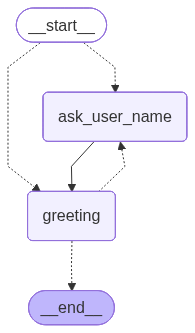

In [ ]:
display(Image(app_with_loop.get_graph().draw_mermaid_png()))

### Run application with a given user name and ask thereafter for another one

In [145]:
result = app_with_loop.invoke({USER_NAME_KEY: "John", OUTPUT_KEY: []})
logging.info(pformat(result))

INFO:root:User name: John
INFO:root:let's go to the greeting node
INFO:root:Greeting user: John
INFO:root:Interactive: Ask for more users
INFO:root:let's go to the ask user name node for another user name.
INFO:root:Interactive: Ask for user name
INFO:root:Greeting user: qwdfwqd
INFO:root:Interactive: Ask for more users
INFO:root:let's go to the end node
INFO:root:{'output': ['Hello, John!',
            'Do you want to add another user? (y/n)',
            'Please enter your name: ',
            'Hello, qwdfwqd!',
            'Do you want to add another user? (y/n)'],
 'user_name': 'qwdfwqd'}
